<a href="https://www.kaggle.com/code/pmassouf/lgbm-baseline-score-0-14?scriptVersionId=102436570" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Table of Contents
* [Houses Prices Dataset](#intro)

* [Data Loading and Exploration](#loading)

* [Training](#training)

    - [Split](#split)
    
    - [Cross Validation](#cross_val)
    
    - [RMSE Score](#r2)
    
    - [Plot](#Plot)
    
* [Submission](#sub)

In [2]:
 %config Completer.use_jedi = False


<a id = "intro" ></a>
# Houses Prices Dataset

**Here we have a dataset that contains features for multiple houses in Iowa.**

**The task is to predict what the price of a given house will be.**

**This is a regression problem, we are trying to predict a continuous value**

<a id="loading"></a>
# Data Loading and Exploration

In [3]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


We can see that we have a lot of missing values and categorical columns. We'll use a lgbm algorithm because it handles this type of problems.


In [4]:
df.set_index('Id')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [5]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

we'll convert categorical columns types in categories

In [6]:
df[df.select_dtypes('object').columns]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [7]:
df[df.select_dtypes('object').columns] = df.select_dtypes('object').apply(lambda col: col.astype('category'))

In [8]:
df.dtypes

Id                  int64
MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
                   ...   
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
SalePrice           int64
Length: 81, dtype: object

In [9]:
df.dtypes

Id                  int64
MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
                   ...   
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
SalePrice           int64
Length: 81, dtype: object

<a id = "training"></a>
# Training and Evalutation

<a id = "split"></a>

# Split

In [10]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<a id = "cross_val"></a>

# Cross Validation

In [11]:
from lightgbm import LGBMRegressor
from lightgbm import cv
from lightgbm import Dataset
from sklearn.metrics import mean_squared_error

#we implement the competition metric
def log_rmse(preds, train_data):
    y_true = train_data.get_label()
    y_hat = np.round(preds)
    return 'l_rmse', mean_squared_error(np.log(y_true),np.log(y_hat),squared=False), True

lgbm = LGBMRegressor(objective='regression', random_state=0)
lgbm.fit(X_train, y_train)
test_dataset = Dataset(X_test, y_test, feature_name = "auto")
res = cv( 
        params = {'objective': 'regression', "metric" : "None"},
        train_set = test_dataset,
        num_boost_round=100,
        nfold=5,
        feval=log_rmse,
        stratified=False)

print(res)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 348, number of used features: 74
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 348, number of used features: 74
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 348, number of used features: 74
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_

<a id = "r2"></a>

# RMSE score



In [12]:
RMSE  = res['l_rmse-mean'][-1]

In [13]:
print(" RMSE :  {}".format(RMSE))


 RMSE :  0.15336170624293097


<a id = "Plot"></a>
# Plot

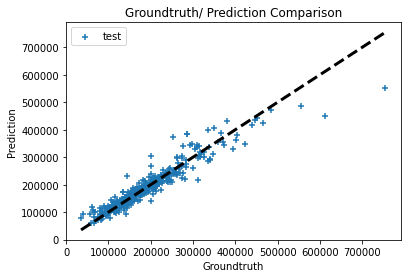

In [14]:

y_test_pred = lgbm.predict(X_test)
xmin= min(y_test.values.min(), y_test_pred.min() )-1
xmax= max(y_test.values.max(), y_test_pred.max() )+1
fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction') 
plt.title('Groundtruth/ Prediction Comparison')
plt.legend()

We can see that the values are very close to the y=x curve. That means that the prediction and the ground truth are similar.

<a id = "sub"></a>
# Submission

In [15]:
X_f  = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


In [16]:
ids = X_f['Id']
X_f[X_f.select_dtypes('object').columns] = X_f.select_dtypes('object').apply(lambda col: col.astype('category'))
y_f = lgbm.predict(X_f)
sub = pd.DataFrame({'Id': ids.values, 'SalePrice' : y_f})

In [17]:
sub

,Id,SalePrice
0,1461,127133.102075
1,1462,154256.777559
2,1463,195577.797365
3,1464,193725.537605
4,1465,187909.880324
...,...,...
1454,2915,78458.102967
1455,2916,92201.420340
1456,2917,160959.328544
1457,2918,120919.873442


In [18]:
sub.to_csv('./submission.csv', index=False)